#  Telecom Churn - ML Froup Case Study

authors : Seetharam Rao | Jesal Patel

# Business Problem Overview
* In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
* For many incumbent operators, retaining high profitable customers is the number one business goal.
* To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

# Understanding and Defining Churn
* There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

* In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

* However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

* Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.

This project is based on the Indian and Southeast Asian market.

In [1]:
# import sys
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# sys.path.append('/content/drive/My Drive/Telecom_Churn_Casestudy/')

In [2]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns",100)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Import Decision Tree Classifier machine learning Library
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier

# Step:0 Data Import

In [3]:
# path = '/content/drive/My Drive/Telecom_Churn_Casestudy/telecom_churn_data.csv'
# path = 'D:\Disc_von_Wolke\GoogleDrive\UpGrad_ML_AI_coursebook\PGDM_ML_AI_IIIT_B\4_Machine Learning-2\ML2_module_9\Telecom_Churn_Case_Study'
telecom_data = pd.read_csv('telecom_churn_data.csv')
print(f"Dataset shape and size:-{telecom_data.shape} \n")
telecom_data.info()

Dataset shape and size:-(99999, 226) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [4]:
random_val =  101

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

# Unique levels of data in columns
def get_unique(data,cat_min,cat_max):
    unique_df_column = []
    unique_df_unique_values = []
    unique_df_unique_len = []
    unique_df = pd.DataFrame()
    column = list(data.columns)
    for var in range(len(data.columns)):
        if ((data[column[var]].nunique()<= cat_max) & (data[column[var]].nunique()> cat_min)):
            unique_df_column.append(column[var])
            unique_df_unique_values.append(data[column[var]].unique())
            unique_df_unique_len.append(data[column[var]].nunique())
    unique_df = pd.DataFrame({'column':unique_df_column,'unique_values':unique_df_unique_values,'unique_len':unique_df_unique_len})
    return unique_df

def extract_quantiles(df,low,high):
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
    #   if is_numeric_dtype(df[name]):
        df = df[(df[name] >= quant_df.loc[low, name]) & (df[name] <= quant_df.loc[high, name])]
    return df

def highlight_greaterthan_1(s):
    if s.scores > 0.70:
        return ['background-color: lightgreen']*2
    else:
        return ['background-color: red']*2

from sklearn import metrics

def get_scores(actual,predicted):
    confusion = metrics.confusion_matrix(actual, predicted)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    confusion_df = pd.DataFrame({'true_positive':[TP],'true_negative':[TN],'false_positive':[FP],'false_negative':[FN]}, index=[0])

    scores_list = [(metrics.roc_auc_score(actual, predicted)),(metrics.precision_score(actual, predicted)),(TP / float(TP+FN)),\
                  (TN / float(TN+FP)), (FP / float(TN+FP)),(TP / float(TP+FP)),(TN / float(TN+ FN)),\
                  ( metrics.accuracy_score(actual, predicted)),metrics.mean_squared_error(actual, predicted)]
    metrics_list = ['Roc_auc_score','precision_score','Sensitivity/Recall','Specificity','False Positive Rate','Positive predictive value:','Negative Predictive value','Accuracy','mean squared error']
    scores_df = pd.DataFrame({'metrics':metrics_list,'scores':scores_list})
    scores_df = scores_df.style.apply(highlight_greaterthan_1,axis=1)
    draw_roc(actual,predicted)
    return confusion_df,scores_df

#  Step:1 Data Cleaning and EDA

 * ### Exploring Dataset Statistics 

In [5]:
telecom_data.dtypes

mobile_number       int64
circle_id           int64
loc_og_t2o_mou    float64
std_og_t2o_mou    float64
loc_ic_t2o_mou    float64
                   ...   
aon                 int64
aug_vbc_3g        float64
jul_vbc_3g        float64
jun_vbc_3g        float64
sep_vbc_3g        float64
Length: 226, dtype: object

In [6]:
cat_cols = list(telecom_data.select_dtypes(include=['object']).columns)
print("number of categorical columns = {} ".format(len(cat_cols)))
#print(f"{list(cat_cols)}")
num_cols = list(telecom_data.select_dtypes(include=['int','float']).columns)
print("number of continuous columns = {} ".format(len(num_cols)))
#print(list(num_cols))

number of categorical columns = 12 
number of continuous columns = 179 


In [7]:
# calculating the null percentage of each column
null_values = pd.DataFrame({'null_val':round(100*telecom_data.isnull().sum()/len(telecom_data),2)})
null_values = null_values[null_values['null_val']>0]
print(f"Number of columns with null values :- {null_values.shape[0]}")
null_values.sort_values(by='null_val',ascending=False).head()

Number of columns with null values :- 166


,null_val
count_rech_2g_6,74.85
max_rech_data_6,74.85
arpu_3g_6,74.85
av_rech_amt_data_6,74.85
count_rech_3g_6,74.85


In [8]:
#Listing columns having more than 50% of NA data
set_null_percent = 50
null_values = null_values.loc[null_values['null_val']>set_null_percent]
print(f"Number of columns with null values > 50% :- {null_values.shape[0]}")
null_values.sort_values(by='null_val',ascending=True).head()

Number of columns with null values > 50% :- 40


,null_val
date_of_last_rech_data_8,73.66
night_pck_user_8,73.66
arpu_2g_8,73.66
total_rech_data_8,73.66
arpu_3g_8,73.66


In [9]:
# Here date time columns are not of use because we are not dealing with time-series data
cols_date_time = telecom_data.columns[telecom_data.columns.str.contains(pat = 'date_')] 
print(f"Droping time-series data \n\n{cols_date_time}")
# Dropping the above date-time related columns
telecom_data.drop(columns= cols_date_time,inplace=True)
print(f"\nNo of columns after dropping time-series data :- {telecom_data.shape[1]}")

Droping time-series data 

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9'],
      dtype='object')

No of columns after dropping time-series data :- 214


In [10]:
# droping columns having unique values, doen't add info for model building
unique_list = telecom_data.columns[(telecom_data.nunique() == 1)]
print(f"Columns containing single unique values :-\n\n{unique_list}")
telecom_data.drop(columns=unique_list,inplace=True)
print(f"\nNo of columns after dropping 1 Unique value columns:- {telecom_data.shape[1]}")

Columns containing single unique values :-

Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7',
       'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'],
      dtype='object')

No of columns after dropping 1 Unique value columns:- 202


In [11]:
# Unique levels of data in columns
print(f"Number of Columns having 2 unique value :- \n")
column = list(telecom_data.columns)
column_multi_lev = []
cat_levels = [0,2]
for var in range(len(telecom_data.columns)):
    if ((telecom_data[column[var]].nunique()<= cat_levels[1]) & (telecom_data[column[var]].nunique()> cat_levels[0])):
        print(column[var],telecom_data[column[var]].unique(),telecom_data[column[var]].nunique())
        column_multi_lev.append(column[var])

Number of Columns having 2 unique value :- 

night_pck_user_6 [ 0. nan  1.] 2
night_pck_user_7 [ 0. nan  1.] 2
night_pck_user_8 [ 0. nan  1.] 2
night_pck_user_9 [nan  0.  1.] 2
fb_user_6 [ 1. nan  0.] 2
fb_user_7 [ 1. nan  0.] 2
fb_user_8 [ 1. nan  0.] 2
fb_user_9 [nan  1.  0.] 2


In [12]:
print(f"Replacing nan with zero for categorical-2 columns\n")
telecom_data[column_multi_lev] = telecom_data[column_multi_lev].fillna(0, axis=1)
telecom_data[column_multi_lev].describe().T

Replacing nan with zero for categorical-2 columns



,count,mean,std,min,25%,50%,75%,max
night_pck_user_6,99999.0,0.006310,0.079185,0.0,0.0,0.0,0.0,1.0
night_pck_user_7,99999.0,0.005890,0.076521,0.0,0.0,0.0,0.0,1.0
night_pck_user_8,99999.0,0.005490,0.073892,0.0,0.0,0.0,0.0,1.0
night_pck_user_9,99999.0,0.004140,0.064210,0.0,0.0,0.0,0.0,1.0
fb_user_6,99999.0,0.230002,0.420836,0.0,0.0,0.0,0.0,1.0
fb_user_7,99999.0,0.232382,0.422354,0.0,0.0,0.0,0.0,1.0
fb_user_8,99999.0,0.234632,0.423771,0.0,0.0,0.0,0.0,1.0
fb_user_9,99999.0,0.223182,0.416382,0.0,0.0,0.0,0.0,1.0


In [13]:
# calculating the null percentage column having greater than 50%
cutt_off_val = 50.0
null_values = pd.DataFrame({'null_val':round(100*telecom_data.isnull().sum()/len(telecom_data),2)})
null_values = null_values.loc[null_values['null_val']>cutt_off_val]
print(f"No of columns having nan > 50% :- {null_values.shape[0]}")
null_values.sort_values(by='null_val',ascending=False).head()

No of columns having nan > 50% :- 28


,null_val
total_rech_data_6,74.85
av_rech_amt_data_6,74.85
arpu_2g_6,74.85
max_rech_data_6,74.85
count_rech_2g_6,74.85


In [14]:
# Filling Nan with zero to seperate high customer row
hig_cust_col = ['count_rech_2g_6','count_rech_3g_6','count_rech_2g_7','count_rech_3g_7',\
               'av_rech_amt_data_6','av_rech_amt_data_7']
telecom_data[hig_cust_col] = telecom_data[hig_cust_col].fillna(0, axis=1)

In [15]:
# sum of data recharges for the months 6,7
telecom_data['total_rech_count_data_6'] = (telecom_data['count_rech_2g_6']+\
                                           telecom_data['count_rech_3g_6'])
telecom_data['total_rech_count_data_7'] = (telecom_data['count_rech_2g_7']+\
                                           telecom_data['count_rech_3g_7'])
# total amount recharging data the months 6,7
telecom_data['total_rech_amt_data_6'] = (telecom_data['total_rech_count_data_6']\
                                          *telecom_data['av_rech_amt_data_6'])
telecom_data['total_rech_amt_data_7'] = (telecom_data['total_rech_count_data_7']\
                                         *telecom_data['av_rech_amt_data_7'])

In [16]:
#total monthly recharge for data and call , summing amounts spents on call and data recharge for the month.
telecom_data['total_month_rech_6'] = (telecom_data['total_rech_amt_6']\
                                      +telecom_data['total_rech_amt_data_6'])
telecom_data['total_month_rech_7'] = (telecom_data['total_rech_amt_7']\
                                      +telecom_data['total_rech_amt_data_7'])
#High value customers segmentation 
high_value_cust = telecom_data[telecom_data[['total_month_rech_6','total_month_rech_7']].mean(axis=1)\
                               >=telecom_data[['total_month_rech_6','total_month_rech_7']]\
                               .mean(axis=1).quantile(0.7)]
print(f"Total No of high value customers are :- {high_value_cust.shape[0]/1024:0.2f}k")

Total No of high value customers are :- 29.30k


In [17]:
# Labeling Churn vs Non Churn customers
churn_col = ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
churn_dt = high_value_cust[churn_col]
high_value_cust.insert(loc=1,column='churn',value=0)
# churn customer are labelling as 1 
high_value_cust.loc[(churn_dt <= 0).all(axis=1),'churn'] = 1

In [18]:
print(f"No of Non Churn custormers {sum(high_value_cust['churn']==0)}")
print(f"No of Churn custormers     {sum(high_value_cust['churn']==1)}")

No of Non Churn custormers 27560
No of Churn custormers     2441


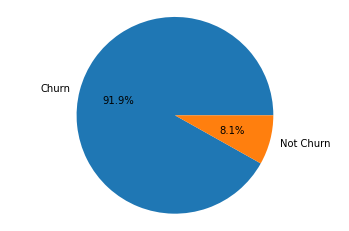

This is a class imbalance problem


In [19]:
# Looking at the values of Yes and No's in the target variable CHURN
labels = ['Churn','Not Churn']
sizes = [high_value_cust['churn'].value_counts()[0],high_value_cust['churn'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.show()
plt.show()
print('This is a class imbalance problem')

In [20]:
# drop all columns belong to 9th month  
high_value_cust.drop(columns=high_value_cust.columns\
                     [high_value_cust.columns.str.contains(pat = '_9')],inplace=True)
# dropping other unused columns
high_value_cust.drop(columns=['sep_vbc_3g','mobile_number'],inplace=True)
print(f"No of Columns after removing 9th month data {high_value_cust.shape[1]}")

No of Columns after removing 9th month data 158


In [21]:
# calculating the null percentage of each column
null_values = pd.DataFrame({'null_val':round(100*high_value_cust.isnull().sum()/len(high_value_cust),2)})
null_values = null_values.loc[null_values['null_val']>0.0]
null_values.sort_values(by='null_val',ascending=False).head()

,null_val
arpu_2g_8,46.83
arpu_3g_8,46.83
max_rech_data_8,46.83
count_rech_2g_8,46.83
count_rech_3g_8,46.83


In [22]:
high_value_cust = high_value_cust.fillna(0,axis=1)
print(f"Filling nan values with zero")

Filling nan values with zero


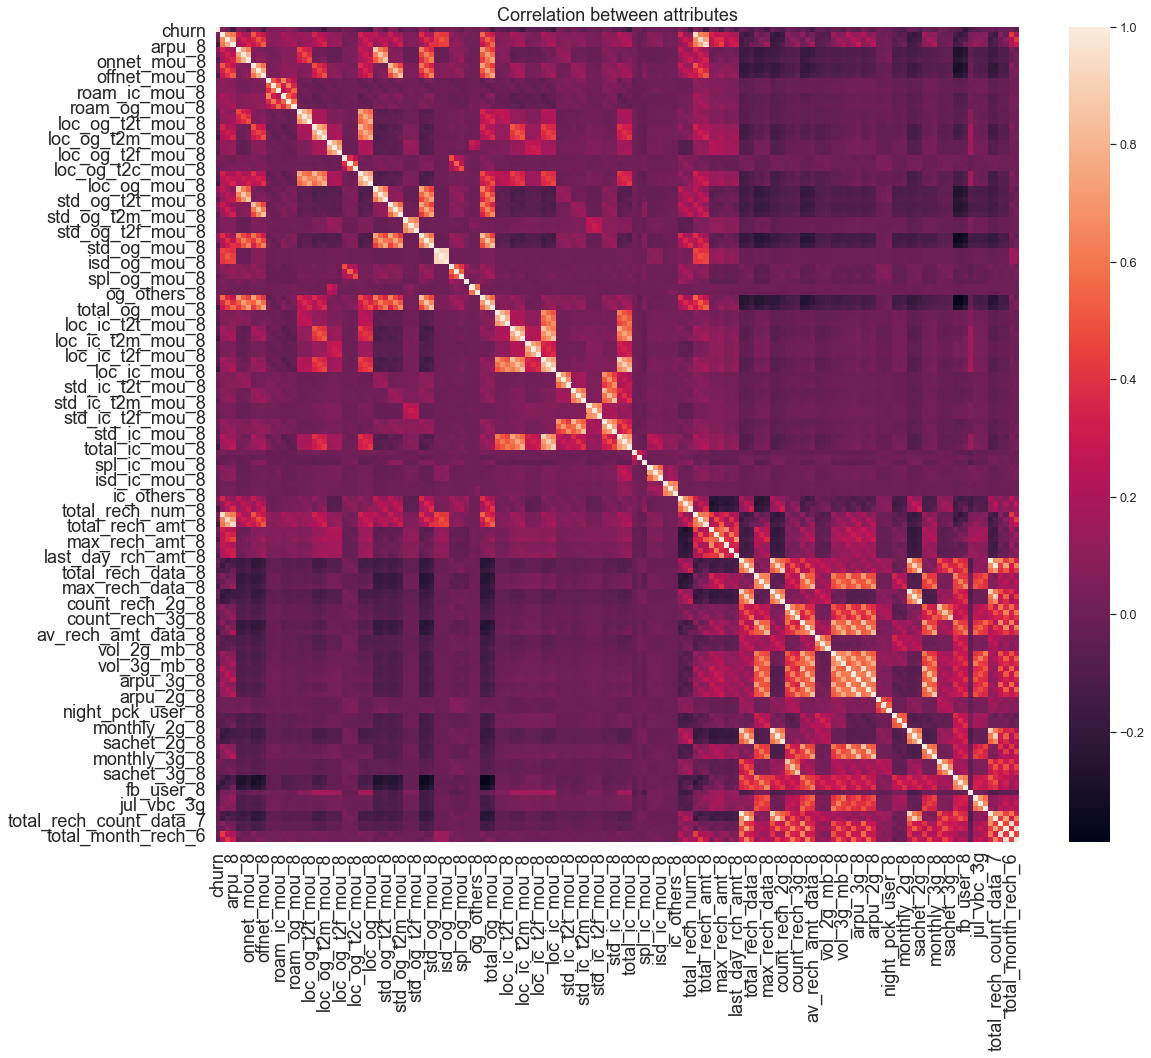

In [23]:
# correlation plot---heatmap
sns.set(font_scale=1.15)
fig,ax=plt.subplots(figsize=(18,15))
sns.heatmap(high_value_cust.corr())
plt.title('Correlation between attributes',fontsize=18)
ax.tick_params(labelsize=18)

As we can see there are lot of correlated variables

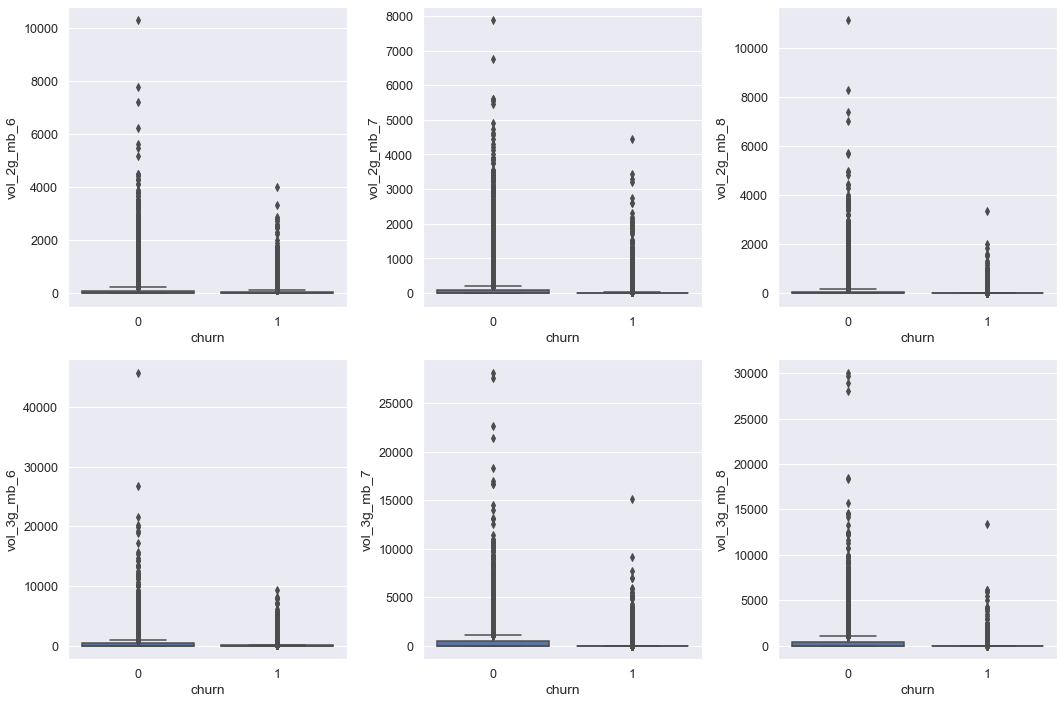

In [24]:
fig, ax=plt.subplots(2,3,figsize=(15,10))
sns.boxplot(y='vol_2g_mb_6',x='churn',data=high_value_cust,ax=ax[0][0])
sns.boxplot(y='vol_2g_mb_7',x='churn',data=high_value_cust,ax=ax[0][1])
sns.boxplot(y='vol_2g_mb_8',x='churn',data=high_value_cust,ax=ax[0][2])
sns.boxplot(y='vol_3g_mb_6',x='churn',data=high_value_cust,ax=ax[1][0])
sns.boxplot(y='vol_3g_mb_7',x='churn',data=high_value_cust,ax=ax[1][1])
sns.boxplot(y='vol_3g_mb_8',x='churn',data=high_value_cust,ax=ax[1][2])
plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

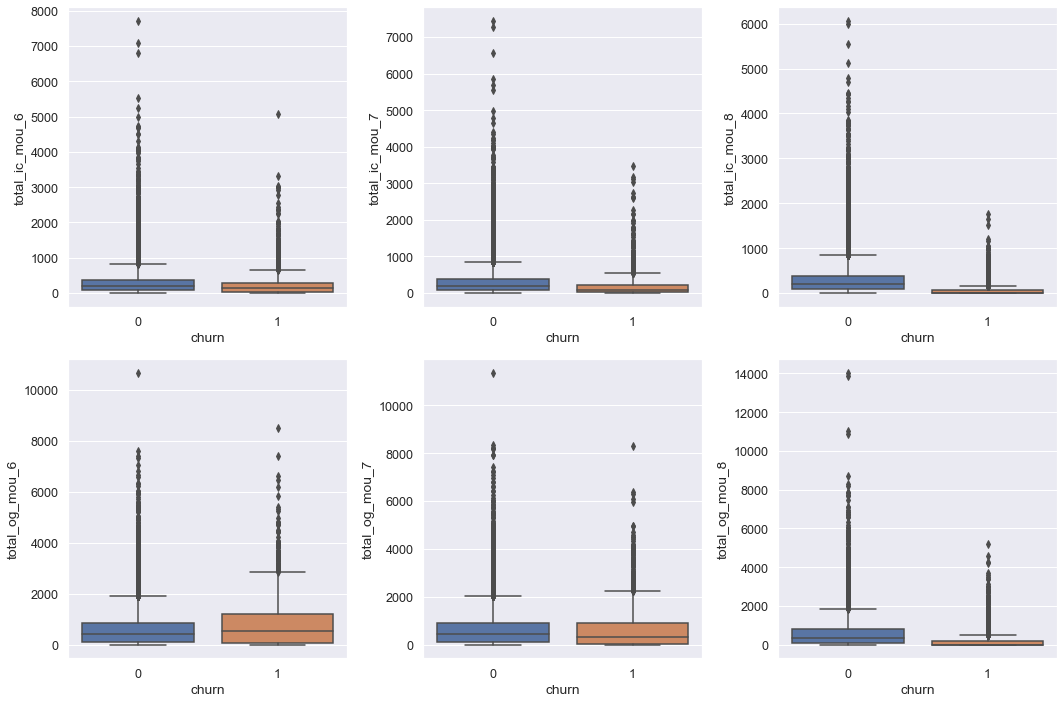

In [25]:
fig, ax=plt.subplots(2,3,figsize=(15,10))
sns.boxplot(y='total_ic_mou_6',x='churn',data=high_value_cust,ax=ax[0][0])
sns.boxplot(y='total_ic_mou_7',x='churn',data=high_value_cust,ax=ax[0][1])
sns.boxplot(y='total_ic_mou_8',x='churn',data=high_value_cust,ax=ax[0][2])
sns.boxplot(y='total_og_mou_6',x='churn',data=high_value_cust,ax=ax[1][0])
sns.boxplot(y='total_og_mou_7',x='churn',data=high_value_cust,ax=ax[1][1])
sns.boxplot(y='total_og_mou_8',x='churn',data=high_value_cust,ax=ax[1][2])
plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

###From this we can drop data total_ic_mou_6 col above 3200 which doesn't have much churn data

In [26]:
### more than 3200 and above in total_ic_mou_6 and treat as outlier and don't effect much of churn data
cp_hig_val = high_value_cust.copy()
cp_hig_val.shape
#high_value_cust = cp_hig_val.copy()

(30001, 158)

In [27]:
high_value_cust = high_value_cust[high_value_cust['total_ic_mou_6'] < 3200]
high_value_cust.shape

(29961, 158)

In [28]:
print(f"No of Non Churn before outlier treatment {sum(cp_hig_val['churn']==0)}")
print(f"No of Non Churn after outlier treatment  {sum(high_value_cust['churn']==0)}\n")
print(f"No of Churn before outlier treatment {sum(cp_hig_val['churn']==1)}")
print(f"No of Churn after outlier treatment  {sum(high_value_cust['churn']==1)}")

No of Non Churn before outlier treatment 27560
No of Non Churn after outlier treatment  27522

No of Churn before outlier treatment 2441
No of Churn after outlier treatment  2439


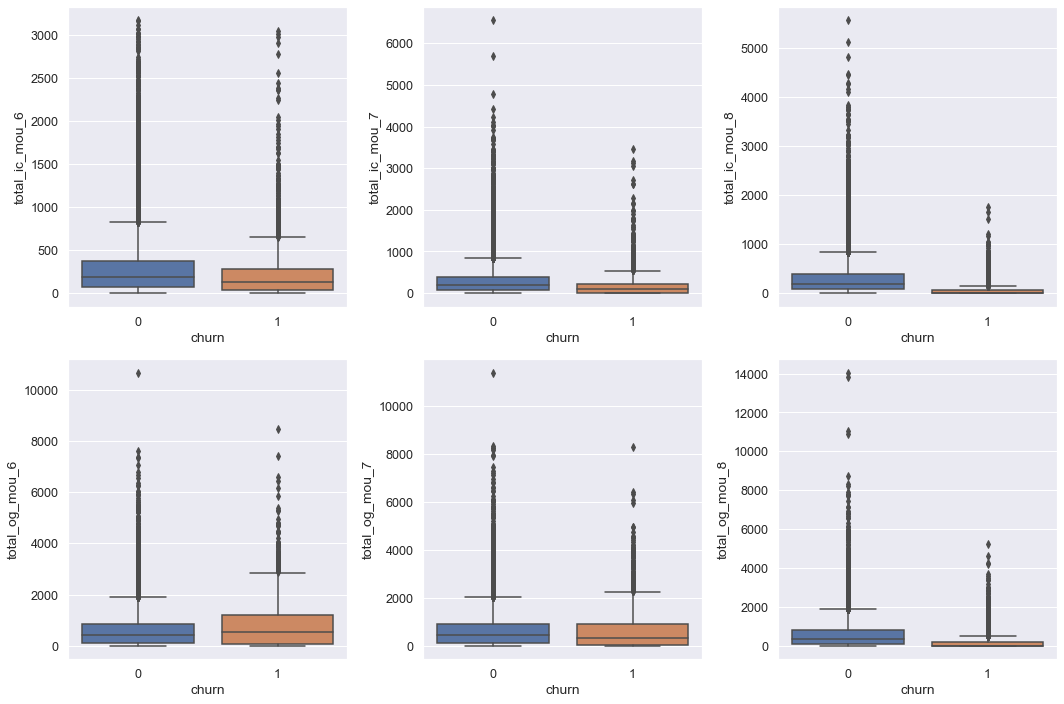

In [29]:
fig, ax=plt.subplots(2,3,figsize=(15,10))
sns.boxplot(y='total_ic_mou_6',x='churn',data=high_value_cust,ax=ax[0][0])
sns.boxplot(y='total_ic_mou_7',x='churn',data=high_value_cust,ax=ax[0][1])
sns.boxplot(y='total_ic_mou_8',x='churn',data=high_value_cust,ax=ax[0][2])
sns.boxplot(y='total_og_mou_6',x='churn',data=high_value_cust,ax=ax[1][0])
sns.boxplot(y='total_og_mou_7',x='churn',data=high_value_cust,ax=ax[1][1])
sns.boxplot(y='total_og_mou_8',x='churn',data=high_value_cust,ax=ax[1][2])
plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

#Data Prep

In [30]:
from sklearn.model_selection import train_test_split

# Splitting 70-30 for train and test dataset
df_train,df_test = train_test_split(high_value_cust,train_size = 0.70, test_size = 0.3, random_state = random_val, stratify=high_value_cust['churn'])

In [31]:
# using min-max scalar for scaling the numerical terms
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar = MinMaxScaler()
# scalar2 = StandardScaler()

df_train[df_train.columns] = scalar.fit_transform(df_train[df_train.columns])
df_test[df_test.columns] = scalar.transform(df_test[df_test.columns])

 Train Dataset :- (20972, 157) 20972
 Test  Dataset :- (8989, 157)  8989


In [32]:
y_train = df_train.pop('churn')
X_train = df_train

y_test = df_test.pop('churn')
X_test = df_test

##### smote

In [33]:
# #perform oversampling using smote
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=12)
# X_train_smo, y_train_smo = sm.fit_sample(X_train, y_train)
# X_train = pd.DataFrame(X_train_smo, columns=X_train.columns)
# y_train = pd.DataFrame({'churn':y_train_smo})

# Base Model : Logistic Regression

### RFE

In [38]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
max_cols = 50
rfe = RFE(logreg, max_cols)             # running RFE 
rfe = rfe.fit(X_train,y_train)

In [40]:
#Iterate from array de rfe.support_ and pick columns that are == True
rfe_cols = list(X_train.columns)
i = 0
cols = []
for e in rfe.support_:
	if e == True:
	    cols.append(rfe_cols[i])
	i = i+1
# sorted(rfe_cols)

In [41]:
X_train_rfe = X_train[rfe_cols]

# logistic model

In [42]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logm1 = LogisticRegression(class_weight="balanced",n_jobs=-1)
logm1.fit(X_train_rfe,y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1)

## Making predictions

In [45]:
#Predict on training set
y_train_pred = logm1.predict(X_train_rfe)
y_train_pred_prob = logm1.predict_proba(X_train_rfe)[:,1]

Train Data evaluation matrics



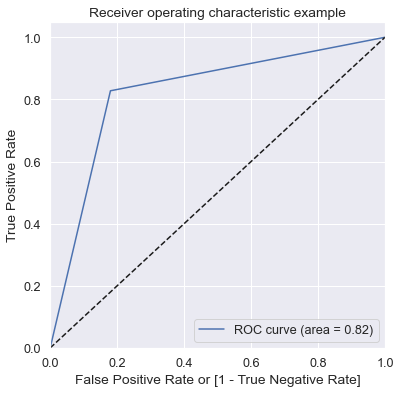

   true_positive  true_negative  false_positive  false_negative
0           1413          15798            3467             294


,metrics,scores
0,Roc_auc_score,0.823902
1,precision_score,0.289549
2,Sensitivity/Recall,0.827768
3,Specificity,0.820036
4,False Positive Rate,0.179964
5,Positive predictive value:,0.289549
6,Negative Predictive value,0.981730
7,Accuracy,0.820666
8,mean squared error,0.179334


In [46]:
print("Train Data evaluation matrics\n")

confusion_train,scores_train = get_scores(y_train,y_train_pred)
print(confusion_train)
scores_train

In [44]:
# Applying transformation on test
Xtest_reduced = pca_final.transform(Xtest)

# Applying logistic model
learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(Xtrain_reduced, y_train)
pred_probs_test = model_pca.predict_proba(Xtest_reduced)

draw_roc(y_test,pred_probs_test[:,1])

print(f"PCA Test Score :- {metrics.roc_auc_score(y_test, pred_probs_test[:,1]):2.2f}")

NameError: name 'Xtrain_reduced' is not defined

In [ ]:
#Importing the PCA module
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
pca = PCA(random_state=100)
pca.fit(Xtrain)
var_cumu = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=[12,8])
plt.vlines(x=34, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.97, xmax=140, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.xlabel('number of components')
plt.show()

In [ ]:
per = 97
print(f"No of columns required for {per}% accuracy is \
{(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)<per).sum()}")

In [ ]:
PCcol = ['PC'+str(x) for x in range(1,158)]
components = pd.DataFrame(pca.components_,columns=PCcol,index=X_train.columns)
pca_dt = components.sort_values(by=PCcol,ascending=True)
pca_dt.head(50)

In [ ]:
pca_col = pca_dt.index[:35]
pca_col = list(pca_col.sort_values())
pca_col

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(X_train[pca_col].corr(),annot = True)

In [ ]:
pca_final = IncrementalPCA(n_components=34)
Xtrain_reduced = pca_final.fit_transform(X_train)
Xtrain_reduced.shape

In [ ]:
corrmat = np.corrcoef(Xtrain_reduced.transpose())
plt.figure(figsize=[20,15])
sns.heatmap(corrmat, annot=True)

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [ ]:
# Applying transformation on test
Xtest_reduced = pca_final.transform(X_test)

# Applying logistic model
learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(Xtrain_reduced, y_train)
pred_probs_test = model_pca.predict_proba(Xtest_reduced)

draw_roc(y_test,pred_probs_test[:,1])

print(f"PCA Test Score :- {metrics.roc_auc_score(y_test, pred_probs_test[:,1]):2.2f}")

In [ ]:
# invoking the decision tree classifier function. Using 'entropy' method of finding the split columns. Other option                             
#,random_state=100,min_samples_leaf=5
dt_model = DecisionTreeClassifier(criterion = 'entropy',random_state=100,max_depth = 5)
#Fitting the model
dt_model.fit(X_train, y_train)

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )
print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns)\
       .sort_values(by='Imp',ascending=False))

In [ ]:
#Making the prediction
y_predict = dt_model.predict(X_test)

In [ ]:
# performance on train data
print('Performance on Training data using DT: ',dt_model.score(X_train , y_train))
# performance on test data
print('Performance on Testing data using DT:  ',dt_model.score(X_test , y_test))
#Evaluate the model using accuracy, confusion metrix, and classification report
acc_pruned_DT=metrics.accuracy_score(y_test, y_predict)
print("Accuracy Pruned DT:",acc_pruned_DT)
print('Confusion Matrix Pruned DT: \n',metrics.confusion_matrix(y_test, y_predict))
print('Classification report Pruned DT: \n',metrics.classification_report(y_test, y_predict))  

In [ ]:
adabst= AdaBoostClassifier(base_estimator=dt_model, n_estimators=100,random_state=100)
adabst = adabst.fit(X_train, y_train)

In [ ]:
y_predict = adabst.predict(X_test)
acc_AB=metrics.accuracy_score(y_test, y_predict)
print('Accuracy using AdaBoosting: ',acc_AB)
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, y_predict))
print('Classification report AdaBoosting: \n',metrics.classification_report(y_test, y_predict))  

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
y_predict = model.predict(X_test)
acc_AB=metrics.accuracy_score(y_test, y_predict)
print('Accuracy using XDABoosting: ',acc_AB)
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, y_predict))
print('Classification report XdaBoosting: \n',metrics.classification_report(y_test, y_predict))  

# Step:8 Model Comparision and Metrics Evaluation

# Key Performance Index and Recommendations 

In [ ]:
# END OF CODE
# Due to a lot of time consumed while running all the lines. this patch will notify when it reaches the end of notebook running all succesfully
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')